In [1]:
import random
from IPython.core.display import SVG
import pyomo.environ as p
from pysat.solvers import Solver
from pysat.formula import CNF
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path
from collections import defaultdict
from itertools import combinations
import time


In [2]:
from IPython.display import IFrame
title_ = 'Minimum Test Collection'
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=700)

In [3]:
model = p.ConcreteModel()

# Визуализация

Без ограничения общности, пусть у нас подмножество $S$ &ndash; численное.

In [4]:
model.InitialSet = range(10)
model.SetLen = len(model.InitialSet)
model.SetIndex = range(model.SetLen)

Зададим семейство подмножеств $С$:

In [5]:
model.InitialSubsets = [[1,2], [1,2,3], [5,6], [6,8,], [0,4,7], [0,1,2,3,4,5,6,7,8,9], [0], [1], [2], [5,7]]

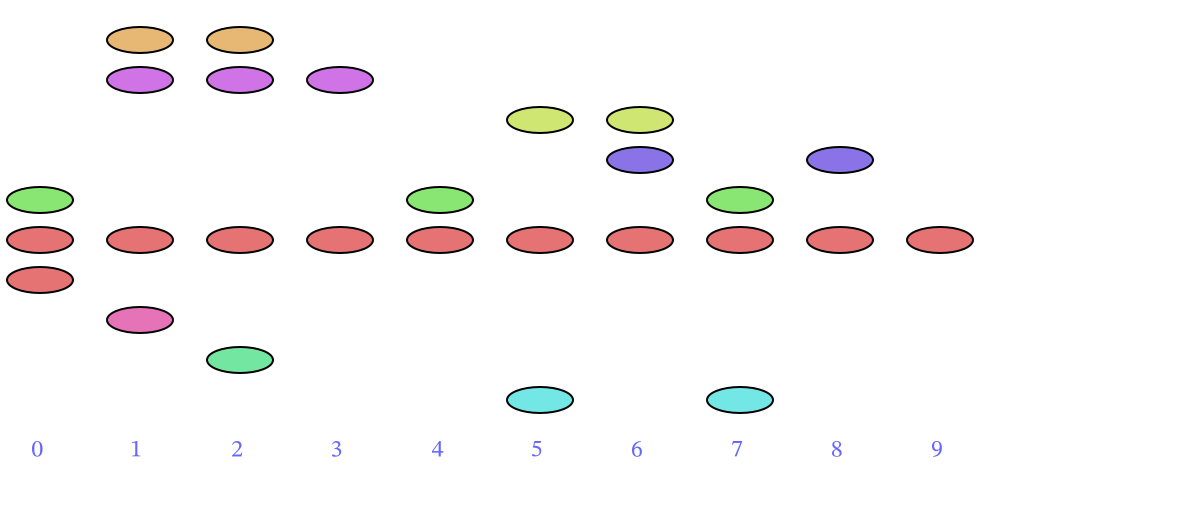

In [6]:
svg = psc.subsets2svg(model.InitialSubsets)
SVG(data=svg)

Запомним его мощность и проиндексируем подмножества.

In [7]:
model.SubsetCount = len(model.InitialSubsets)
model.SubsetIndex = range(model.SubsetCount)

Удобнее будет хранить его в виде таблицы связности: 

$S[i][j] = 1$, если $i$-ое подмножество содержит элемент $j$

In [8]:
S = [[0 for _ in range(model.SetLen)] for _ in range(model.SubsetCount)]

for i in range(model.SubsetCount):
    for elem in model.InitialSubsets[i]:
        S[i][elem] = 1

model.Subsets = S

# Реализация в Pyomo

**Переменная** $x[i] = 1$, если мы берем $i$ подмножество в целевое семейство $C'$ и $0$ в противном случае.

In [9]:
model.x = p.Var(model.SubsetIndex, within=p.Binary)

In [10]:
def display_model(model):
    selected_sets = [subset for subset in model.SubsetIndex if round(model.x[subset]()) == 1]
    return SVG(psc.subsets2svg(model.InitialSubsets, selected=selected_sets))

**Целевая функция** — мощность семейства $C'$, т.е. сумма $x[i]$ по $i$

In [11]:
@model.Objective()
def FinalCapacity(model):
    return sum(model.x[subset] for subset in model.SubsetIndex)

Единственное ограничение:

$$ \forall i,j \in S\; \exists C_k \in C':
\left[ 
      \begin{gathered} 
		i \in C_k, j \notin C_k, \\ 
		i \notin C_k, j \in C_k \\
      \end{gathered} 
\right.
$$


То есть

$$\forall i,j \in S \exists C_k \in C':\; Subsets\left[C_k\right]\left[i\right] XOR \;Subsets\left[C_k\right]\left[j\right] == 1$$

Теперь можно просто заменить существование на сравнение суммы по k с единицей.

In [12]:
@model.Constraint(model.SetIndex, model.SetIndex)
def all_pair_of_elements_are_included_excluded(model, i, j):
    if i <= j:
        return p.Constraint.Feasible
    else:
        return sum(model.x[subset] * (model.Subsets[subset][i] ^ model.Subsets[subset][j]) for subset in model.SubsetIndex) >= 1

Определяем солвер:

In [13]:
solver = p.SolverFactory('cbc')
solver.solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 8.0
  Upper bound: 8.0
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 3
  Number of binary variables: 10
  Number of integer variables: 10
  Number of nonzeros: 3
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
    

In [14]:
selected_sets = [subset for subset in model.SubsetIndex if round(model.x[subset]()) == 1]
selected_sets

[0, 1, 2, 3, 4, 6, 8, 9]

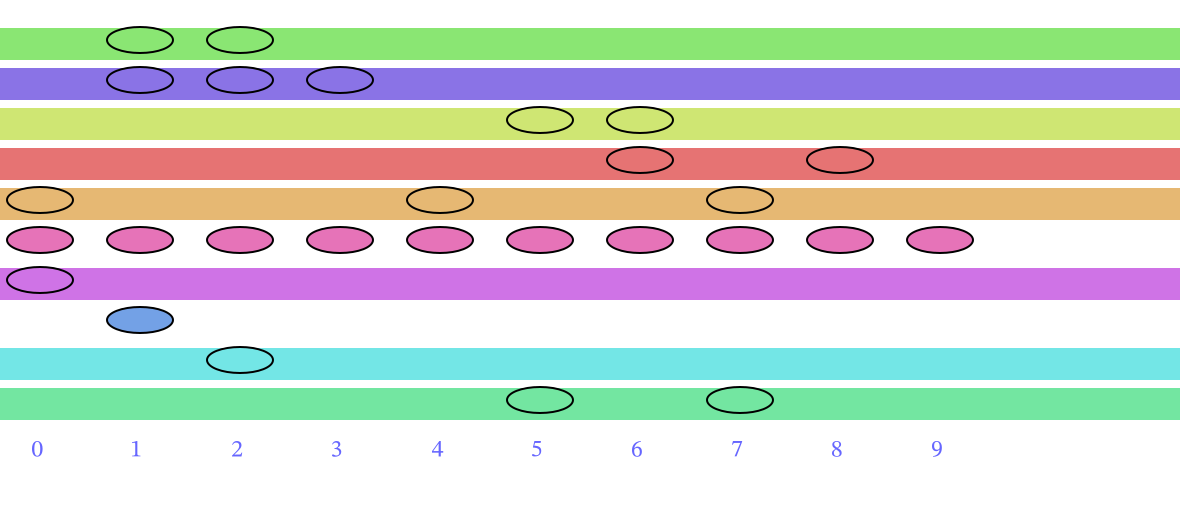

In [15]:
display_model(model)

**StasFomin**: Увы, моя вина, что нечетко (хотя однозначно, как в базе Вигго-Кана) сформулировал. Сейчас обновил формулировку, пояснив примером, о чем эта задача — т.е. это как покрытие, но с дополнительными ограничениями на различимость болезней. Увы, тут уже видно, что «9»-я болезнь не покрывается никакими тестами.

~~~~: Ну, увы, тут уже видно, что выбранный набор не сможет быть «тестом» для выбранного набора «болезней», ибо 9я болезнь не детектируется ничем. Т.е. эта задача как покрытие, но с дополнительными ограничениями на возможность различить болезни. Моя вина, что нечетко это сформулировал (ну так было в оригинале), но увы.

Модель в общем случае:

In [16]:

def MNT_ILP_model(initial_set, initial_subsets):
    """initial_set -- range(k) или range(a, b) со сдвигом"""
    model = p.ConcreteModel()
    
    model.InitialSet = initial_set
    model.SetLen = len(model.InitialSet)
    model.SetIndex = range(model.SetLen)
    
    model.SubsetCount = len(initial_subsets)
    model.SubsetIndex = range(model.SubsetCount)

    # model.InitialSubsets -- значения initial_subsets после сдвига 
    # range(a, b) -> range(b-a), для этого вычитаем из каждого элемента min.
    _min = min(model.InitialSet)
    model.InitialSubsets = [[elem - _min for elem in subset] for subset in initial_subsets]

    S = [[0 for _ in range(model.SetLen)] for _ in range(model.SubsetCount)]

    for i in range(model.SubsetCount):
        for elem in model.InitialSubsets[i]:
            S[i][elem] = 1

    model.Subsets = S

    model.x = p.Var(model.SubsetIndex, within=p.Binary)
    
    @model.Objective()
    def FinalCapacity(model):
        return sum(model.x[subset] for subset in model.SubsetIndex)

    @model.Constraint(model.SetIndex, model.SetIndex)
    def all_pair_of_elements_are_included_excluded(model, i, j):
        if i <= j:
            return p.Constraint.Feasible
        else:
            return sum(model.x[subset] * (model.Subsets[subset][i] ^ model.Subsets[subset][j]) for subset in model.SubsetIndex) >= 1

    return model

### Трансляция к задаче о разрешимости
Если мощность найденного $ C' \subseteq C $ меньше, либо равна, заданного параметра $\gamma(|C|)$, то задача разрешима. Иначе нет.

In [17]:
def is_feasible_pyomo(initial_set, initial_subsets, gamma):
    model = MNT_ILP_model(initial_set, initial_subsets)

    solver = p.SolverFactory('cbc')
    try:
        solution = solver.solve(model)

        if str(solution['Solver'][0]['Termination condition']) == 'optimal' and model.FinalCapacity() <= gamma:
            return True, model
        else:
            return False, None
    except:
        return False, None

In [18]:
is_feasible_pyomo(gamma=100, initial_set=range(5), initial_subsets=[[0,1], [1]])[0]

model.name="unknown";
    - termination condition: infeasible
    - message from solver: <undefined>


False

In [19]:
is_feasible_pyomo(gamma = 4, initial_set=range(5), initial_subsets=[[0,1], [1], [2], [3], [4]])[0]

True

In [20]:
is_feasible_pyomo(gamma = 3, initial_set=range(5), initial_subsets=[[0,1], [1], [2], [3], [4]])[0]

False

# Сведение 3SAT к задаче

Пусть нам дана формула 
$$\Phi(x_1, y_1, z_1, \dots, x_p, y_p, z_p) = \varphi_1(x_1,y_1,z_1) \bigwedge \varphi_2(x_2,y_2,z_2) \dots \varphi_p(x_p,y_p,z_p)$$
Здесь $\varphi_1(x_1,y_1,z_1) = x_1 \bigvee y_1 \bigvee z_1$ &ndash; конъюкция и $x_1, y_1, z_1$ &ndash; булевы литералы, либо их отрицание (например, $\varphi_1(x_1, \overline{x_4}, \overline{x_6})$).

Пусть в $\Phi$ входит **p** конъюкций и **k** независимых булевых переменных (не считая их отрицаний).

### Строим по 3SAT условие для MNT

Исходное множество значений $\textbf{C}$ для задачи Minimum Test Collection(MNT) будет состоять из следующих элементов:
- "0" &mdash; вспомогательный нулевой элемент, не входит ни в одно подмножество семейства $\textbf{C}$,
- "$+\infty$" &mdash; вспомогательный элемент, содержится ровно в одном подмножестве $\textbf{C}$,
- "$\{-1, -2, -3, \dots, -k\}$" &mdash; "ядра" булевых переменных,
- "$\{1, 1.5, 2, 2.5, \dots, p, p + 0.5 \}$" &mdash; "ядра" конъюкций (целые) и вспомогательные элементы (дробные).

Строим исходное семейство подмножеств $\textbf{C}$. В него будут входить следующие подмножества:
- "черное" &mdash; содержит $+\infty$ и все положительные числа. $\textbf{N} = \{+\infty, 1, 1.5, \dots, p, p + 0.5\} \in \textbf{C}$,
- "красные" &mdash; $p$ подмножеств, содержащих ровно 2 элемента: $i$ и $i + 0.5$. $\textbf{R} = \Big\{ \textbf{r} |\; \textbf{r} = \big\{ i, i + 0.5 \big\}, i \in \overline{1\dots p} \Big\} \subset \textbf{C}$ 
- "синие" &mdash; $2k$ подмножеств, половина которых содержит число $-i$ и $conj_i$ (назовем их $\textbf{x}_\textbf{i}$), а вторая половина &mdash; $-i$ и $\overline{conj_i}$ (назовем их $\overline{\textbf{x}_\textbf{i}}$). $\textbf{B} = \Big\{ \textbf{x}_\textbf{i} |\; \textbf{x}_\textbf{i} = \{ -i \} \cup conj_i, i \in \overline{1..k} \Big\} \cup \Big\{ \overline{\textbf{x}_\textbf{i}} |\; \overline{\textbf{x}_\textbf{i}} = \{ -i \} \cup \overline{conj_i}, i \in \overline{1..k} \Big\} \subset \textbf{C}$

#### **Утверждение:** 
Существование решения задачи Minimum Test Collection(MNT) с построенными $\textbf{S}$, $\textbf{C}$ и $gamma = 1 + p + k$ эквивалентно существованию решения 3-SAT: $\Phi(x_1, \overline{x_1}, x_2, \overline{x_2}, \dots, x_k, \overline{x_k}) = 1$.

<center> или </center>

$$ \exists C' \text{ -- решение MNT}(S,C,gamma) \Longleftrightarrow \exists \{x^*_1, x^*_2, \dots x^*_k\} \text{ -- решение 3SAT: } \Phi(x_1, \overline{x_1}, x_2, \overline{x_2}, \dots, x_k, \overline{x_k}) = 1 $$

#### **Доказательство:**

**Влево:**
Пусть набор $ \{x^*_1, x^*_2, \dots x^*_k\} \text{ -- решение 3SAT: } \Phi(x_1, \overline{x_1}, x_2, \overline{x_2}, \dots, x_k, \overline{x_k}) = 1 $. \
Решим MNT с заданными $\textbf{S}, \textbf{C}$ и $gamma = 1 + p + k$. Выберем из $\textbf{C}$ следующие подмножества:
- "черное",
- все "красные",
- "синие" по следующему правилу: для каждого $i \in \overline{1..k}$, если $x^*_i = 1$ &mdash; берем $\{-i \} \cup conj_i \in \textbf{B}$, если $x^*_i = 0$ &mdash; берем $\{-i \} \cup \overline{conj_i} \in \textbf{B}$

Итого $ |C'| = 1 + p + k $ подмножеств выбрано.

Докажем, что такой выбор подмножеств удовлетворяет условию MNT:\
Покажем, что каждый элемент из $\textbf{S}$ ни конфликтует ни с каким другим (т.е. для любой пары есть подмножество из |C'|, содержащее один элемент, но не второй):
- Нулевой элемент
    - $+\infty$: входит в "черное", а "0" &mdash; нет,
    - Отрицательные числа: $\forall i \in \overline{1..k}$ вы взяли "синее", содержащее $-i$, но не "0",
    - Положительные числа: каждое положительное число входит в "красное", куда не входит "0", "красные" взяли все.
- $+\infty$
    - Отрицательные числа: не входят в "черное", куда входит $+\infty$,
    - Положительные числа: каждое положительное число входит в "красное", куда не входит $+\infty$, "красные" взяли все.
- Отрицательные числа
    - Другие отрицательные: $\forall i \in \overline{1..k}$ вы взяли "синее", содержащее единственное отрицательное число: $-i$,
    - Положительные числа: входят в "черное", куда не входят отрицательные.
- Дробные положительные:
    - Другие дробные: в каждом "красном" ровно одно дробное число, "красные" взяли все.
    - Целые положительные (не из "красного", в которое входит исходное дробное): берем это "красное".
- Целые положительные:
    - Другие целые положительные: в каждом "красном" ровно одно целое число, "красные" взяли все. 

Итак, не разобрана только одна связь: дробные положительные и целые положительные, входящие в одно "красное" подмножество.\
Пусть в 3SAT-задаче $\varphi_i = x_a \bigvee x_b \bigvee x_c$. Тогда, по построению, целое число $i$, помимо 1 "черного" и 1 "красного" подмножества, потенциально входит в 3 "синих": в те, что содержат числа $-a, -b, -c$ ($\{-a\} \cup conj_a$ и т.д.). При этом, исходная задача разрешима, значит $x^*_a = 1$, или $x^*_b = 1$, или $x^*_c = 1$, значит, по построению "синих", мы выбрали в $C'$ одно из этих трёх "синих". Таким образом это "синее" подмножество разрешает конфликт между $i$ и $i + 0.5$.

**Замечание**: если $\varphi_i = \overline{x_a} \bigvee x_b \bigvee \overline{x_c}$, идея выше не поменяется, в таком случае $x^*_a = 0$, или $x^*_b = 1$, или $x^*_c = 0$ и $i$ входит в одно из ($\{-a\} \cup \overline{conj_a}$, или $\{-b\} \cup conj_b$, или $\{-c\} \cup \overline{conj_c}$).

**Вправо:**

Пусть $C'$ &mdash; решение MNT( $\mathbf{S}$, $\mathbf{C}$, $gamma = 1 + p + k$).\
Заметим, что исходя из построенного $\mathbf{S}$ и $\mathbf{C}$, чтобы не было конфликтов между элементами $\mathbf{S}$:
1) "Черное" подмножество входит в $C'$, иначе конфликт между "0" и $+\infty$ ("0" не входит ни в одно, $+\infty$ входит только в "черное" ).
2) Чтобы исключить конфликт между $+\infty$ и дробными положительными, а так как каждое дробного положительного входит только в "черное" (что не решает конфликт) и в одно "красное", необходимо внести все "красные" в $C'$.\
**Мы уже потратили $1 + p$ подмножеств.**
3) Чтобы исключить конфликт между "0" и отрицательными числами, для каждого $i \in \overline{1..k}$ необходимо взять в $C'$ либо $\textbf{x}_\textbf{i} = \{-i\} \cup conj_i$, либо $\overline{\textbf{x}_\textbf{i}} = \{-i\} \cup \overline{conj_i}$.\
При этом нам осталось доступно только $gamma - 1 - p = k$ подмножеств, значит для каждого $i \in \overline{1..k}$ надо взять одно и ровно одно: $\textbf{x}_\textbf{i}$ или $\overline{\textbf{x}_\textbf{i}}$.
4) Чтобы устранить конфликт между дробными и целыми положительными, находящимися в одной "красной" (т.е. между $i$ и $i + 0.5$), для каждого $i \in \overline{1..p}$ в $C'$ должно быть хотя бы одно "синее" подмножество, содержащее $i$.

Докажем, что из этих выводов следует, что набор $\{x^*_1, x^*_2, \dots x^*_k\}$, где
\begin{equation}
x^*_i = 
	\begin{cases}
		1 &, \text{мы выбрали }\textbf{x}_\textbf{i} (\textbf{x}_\textbf{i} \in C' )\\
        0 &, \text{мы выбрали } \overline{\textbf{x}_\textbf{i}} (\overline{\textbf{x}_\textbf{i}} \in C')
	\end{cases}
\end{equation}
является решением исходной 3SAT.

Из (3) следует, что $x^*_i$ определяется однозначно $\forall i \in \overline{1..k}$.\
Из (4) следует, что $\forall i \in \overline{1..p}\; \exists$ хотя бы одно "синее" подмножество, содержащее $i$, лежащее в $C'$. Пусть это синее подмножество сформировано вокруг элемента $-k\_i$, то есть это $\textbf{x}_\textbf{k\_i}$, если $x_{k\_i}$ входит в $\varphi_i$, либо $\overline{\textbf{x}_\textbf{k\_i}}$, если в $\varphi_i$ входит $\overline{x_{k\_i}}$ . Таким образом:
$$ \left[ 
	\begin{gathered} 
		\forall i \in \overline{1..p} \; \exists \textbf{x}_\textbf{k\_i} \in C':\; x_{k\_i} \in \varphi_i \\
		\forall i \in \overline{1..p} \; \exists \overline{\textbf{x}_\textbf{k\_i}} \in C':\; \overline{x_{k\_i}} \in \varphi_i
	\end{gathered} 
\right.$$

То есть для каждой конъюкции $\varphi_i$ из $\Phi = \varphi_1 \wedge \varphi_2 \wedge \dots \wedge \varphi_p$ (т.е. для каждого положительного целого элемента) есть хотя бы один элемент $x^*_{k\_i} = 1$ (либо $\overline{x^*_{k\_i}} = \overline{0} = 1$), входящий в эту конъюкцию, значит все конъюкции выполняются, значит $\{x^*_1, x^*_2, \dots x^*_k\}$ &mdash; решение $\Phi = 1$.

### Визуализируем

Функция, генерирующая рандомную формулу 3-КНФ 

In [21]:
def Generate_random_3cnf(seed, conjunction_count, variables_count):
    random.seed(seed)
    return CNF(from_clauses=psc.rand3cnf(conjunction_count, variables_count))

In [22]:
cnf = Generate_random_3cnf(3, 4, 5)
cnf.clauses

[(-2, 5, 4), (-3, 1, 5), (3, 5, -4), (5, 3, -1)]

Функция, превращающая любую 3-КНФ формулу в экземляр задачи MNT (тройку (S, C, gamma)) по алгоритму, описанному выше.


In [23]:
def transform_3cnf_to_MNT(cnf3):
    clauses = cnf3.clauses

    var_names = set()
    for clause in clauses:
        for var in clause:
            var_names.add(abs(var))
    # psc.rand3cnf всегда называет переменные в порядке от 1 до k (без пробелов)
    
    # Число переменных k
    k = len(var_names)
    # Число конъюкций p
    p = len(clauses)
    # Параметр gamma
    gamma = 1 + k + p

    # Исходное множество значений S.
    # Для простоты положительные числа умножены на 2 и уменьшины на 1 (теперь они не range(1, p + 0.5, step=0.5), а range(1, 2p + 1)),
    # роль infty выполняет 2p + 1.
    S = list(range(-k, 0)) + [0] + list(range(1, 2 * p + 1 )) + [2 * p + 1]
    # Исходное семейство подмножеств С.
    C = []
    # Добавляем "черное"
    C.append(list(range(1, 2 * p + 2)))
    # Добавляем "красные"
    for i in range(0, p):
        C.append([2 * i + 1, 2 * (i + 1)])
    # Добавляем "синие"
    var_in_conj, non_var_in_conj = [[-i] for i in range(1, k + 1)], [[-i] for i in range(1, k + 1)]
    for conj_id, clause in enumerate(clauses):
        for var in clause:
            if var > 0:
                # var_in_conj[0] = [-1]
                var_in_conj[abs(var) - 1].append(2 * conj_id + 1)
            else:
                non_var_in_conj[abs(var) - 1].append(2 * conj_id + 1)
    C.extend(var_in_conj)
    C.extend(non_var_in_conj)
    return S, C, gamma

Пример того, что выдает эта функция.

In [24]:
cnf3 = Generate_random_3cnf(seed=1, conjunction_count=3, variables_count=2)

print(f'Исходная задача: {cnf3.clauses}')

(initial_set, initial_subsets, gamma) = transform_3cnf_to_MNT(cnf3)

print(f'initial_set: {initial_set}')
print(f'initial_subsets: {initial_subsets}')
print(f'gamma: {gamma}')

(is_feasible, model) = is_feasible_pyomo(
    initial_set, initial_subsets, gamma
)

Исходная задача: [(-1, -2), (1, -2), (2, -1)]
initial_set: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
initial_subsets: [[1, 2, 3, 4, 5, 6, 7], [1, 2], [3, 4], [5, 6], [-1, 3], [-2, 5], [-1, 1, 5], [-2, 1, 3]]
gamma: 6


selected_subsets: [[1, 2, 3, 4, 5, 6, 7], [1, 2], [3, 4], [5, 6], [-1, 1, 5], [-2, 1, 3]]


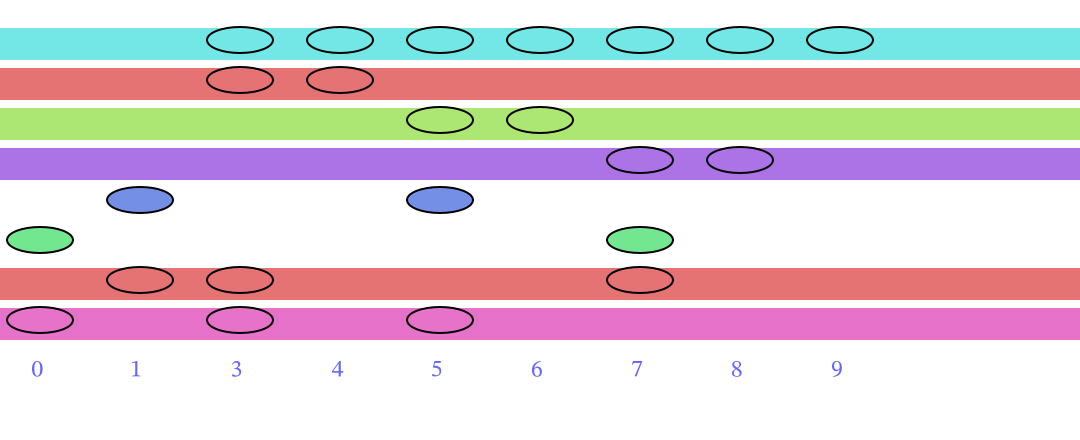

In [25]:
if is_feasible:
    selected_subsets = [initial_subsets[subset] for subset in model.SubsetIndex if round(model.x[subset]()) == 1]
    print(f'selected_subsets: {selected_subsets}')
    svg = display_model(model)
svg

# Проверка выполнимости через ЦЛП и SAT-Solver

Проверка разрешимости 3-КНФ через преобразование к MNT и решение через pyomo-ЦЛП

In [26]:
def is_feasible_ILP(cnf3):
    (initial_set, initial_subsets, gamma) = transform_3cnf_to_MNT(cnf3)
    return is_feasible_pyomo(initial_set, initial_subsets, gamma)[0]

Проверка разрешимости 3-КНФ через pysat Solver

In [27]:
def is_feasible_SAT(cnf3):
    from pysat.solvers import Solver

    solver = Solver(bootstrap_with=cnf3)
    return solver.solve() 

Проверим что это вообще работает на тривиальных 3-КНФ.

In [28]:
true_cnf = CNF(from_clauses=[(1,2,3), (1,-2,-3), (1,2,-3)])
false_cnf = CNF(from_clauses=[(1,2,3), (1,2,-3), (1,-2, 3), (1,-2,-3), (-1,2,3), (-1,2,-3), (-1,-2, 3), (-1,-2,-3),])

is_feasible_SAT(true_cnf), is_feasible_SAT(false_cnf), is_feasible_ILP(true_cnf), is_feasible_ILP(false_cnf), 

(True, False, True, False)

Тест, который генерирует $test\_length$ случайных 3-КНФ формул длины до $max\_conj\_count$ и проверяет, что наш ILP и pysat солвер выдают один и тот же ответ на задачу разрешимости

In [29]:

def run_test(test_length, max_conj_count):
    start = time.time()
    misses_count = 0
    for _ in range(test_length):
        seed = randint(0, 10_000_000)
        conj_count = randint(1, max_conj_count)
        var_count = randint(1, max(1, conj_count // 3))
        Phi = Generate_random_3cnf(seed=seed, conjunction_count=conj_count, variables_count=var_count)

        if is_feasible_ILP(Phi) != is_feasible_SAT(Phi):
            misses_count += 1
            if misses_count % 5 == 0:
                print("Got 5 misses")
    return misses_count, time.time() - start

Теперь просто гоняем тесты

Тест на больших формул:

In [30]:
run_test(10, 50)

(0, 12.412810325622559)

In [31]:
run_test(120, 50)

(0, 156.25865602493286)

Много тестов для формулы поменьше:

In [32]:
run_test(500, 10)

(0, 100.30018091201782)

Судя по результатам, для всех прогнанных тестов задачи были эквивалентны.

Теперь хочется прогнать на совсем больших формулах (и посмотреть, что задачка действительно $NP$: с увеличением входа время растет экспоненциально).

In [33]:
def big_test(conj_count):
    mark1 = time.time()

    Phi = Generate_random_3cnf(seed=randint(0,1_000_000), conjunction_count=conj_count, variables_count=conj_count)
    mark2 = time.time()

    ILP_res = is_feasible_ILP(Phi)
    mark3 = time.time()

    SAT_res = is_feasible_SAT(Phi)
    mark4 = time.time()

    if ILP_res != SAT_res:
        print("Err")
    else:
        print("Ok")
    return mark2 - mark1, mark3 - mark2, mark4 - mark3

In [34]:
big_test(50)

Ok


(0.005578756332397461, 11.565046072006226, 0.0005283355712890625)

In [35]:
big_test(100)

Ok


(0.06852245330810547, 77.0499587059021, 0.00041866302490234375)

In [36]:
big_test(150)

Ok


(0.012944936752319336, 262.47025990486145, 0.0013048648834228516)

In [37]:
# big_test(200)

Судя по времени выполнения, решение 3SAT задачки через ЦЛП &mdash; не лучшая затея.